## <font color=blue> La Modélisation des Cours de Clôture de Microsoft à l'Aide de Réseaux Neuronaux Artificiels </font>

## Qu'est-ce qu'Les réseaux de neurones artificiels ?

  Les réseaux de neurones artificiels (ANN) ou réseaux de neurones simulés (SNN) constituent un sous-ensemble de l'apprentissage automatique et sont au cœur des algorithmes de l'apprentissage en profondeur. Leur nom et leur structure sont inspirés du cerveau humain, imitant la manière dont les neurones biologiques s'envoient des signaux.

 Les réseaux de neurones artificiels (ANN) sont constitués de couches nodales, contenant une couche d'entrée, une ou plusieurs couches cachées et une couche de sortie. Chaque nœud, ou neurone artificiel, se connecte à un autre et possède un poids et un seuil associés. Si la sortie d'un nœud est supérieure à la valeur de seuil spécifiée, ce nœud est activé et envoie des données à la couche suivante du réseau. Sinon, aucune donnée n'est transmise à la couche suivante du réseau.
![download.png](ann_images.png){ width=200px }


## 1. Importation des librairies


In [15]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import r2_score
from pandas.plotting import lag_plot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

## 2. Chargement de données

In [2]:
dataframe=pd.read_csv('Close_Microsoft.csv',header=0,index_col=0,parse_dates=True)
dataframe=dataframe.set_index(dataframe.index)
dataframe.head()

,Close
Date,
2017-01-03,62.580002
2017-01-04,62.299999
2017-01-05,62.299999
2017-01-06,62.840000
2017-01-09,62.639999


# 3. Analyse de données
#### <font color=aqua> *3.1 Mesures descriptives de la dataset Close_Microsoft*</font>

In [3]:
dataframe.describe()

,Close
count,1426.000000
mean,169.588822
std,82.509972
min,62.299999
25%,98.444999
50%,141.455002
75%,243.752502
max,343.109985


#### <font color=aqua> *3.2  Recherche des valeurs manquants*</font>


In [4]:
Missing_Values = dataframe.isnull().sum()

print('Le nombre total des valeurs manquantes dans le jeu de données :\n', Missing_Values)


Le nombre total des valeurs manquantes dans le jeu de données :
 Close    0
dtype: int64


#### <font color=aqua> *3.3 Représentation graphique  de la cloture*</font>

Text(0, 0.5, 'Close')

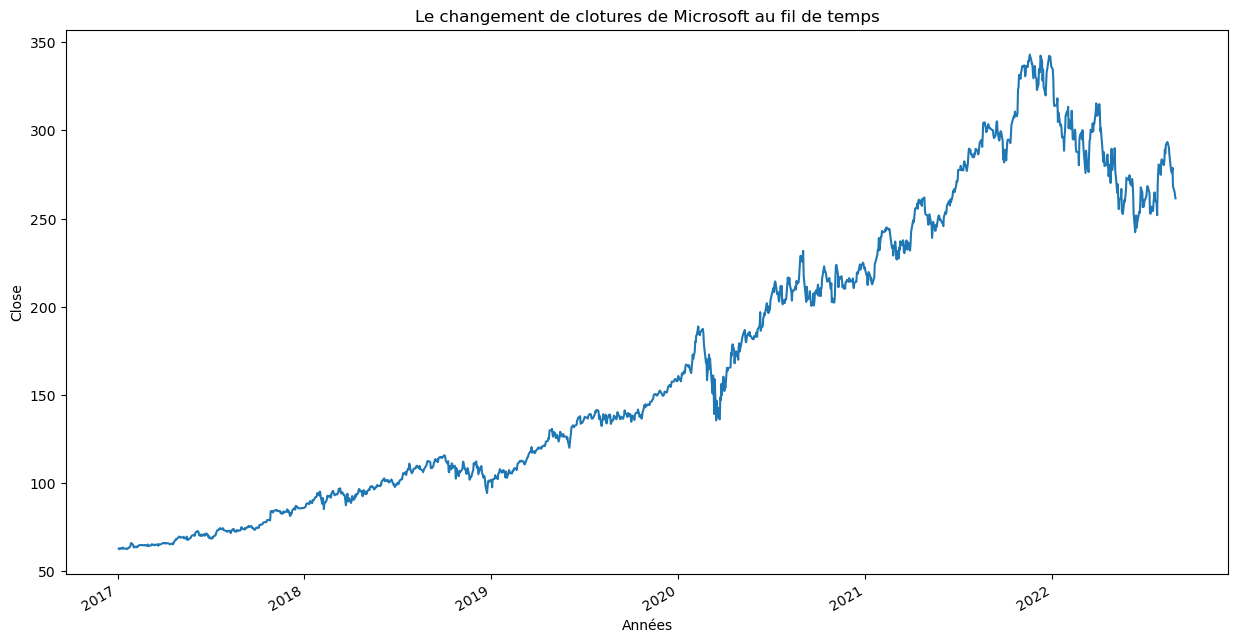

In [5]:
plt.figure(figsize=(15,8))
dataframe['Close'].plot();
plt.title('Le changement de clotures de Microsoft au fil de temps')
plt.xlabel('Années')
plt.ylabel('Close')

#### <font color=aqua> *3.4 Identification des valeurs aberrantes*</font>

Le jeu de données varie entre 2017 et 2022.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'Années')

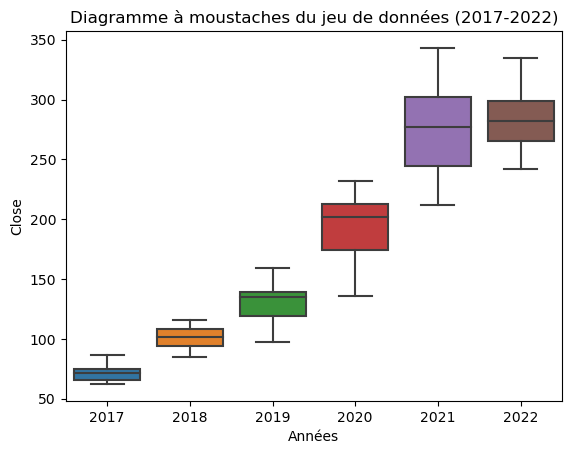

In [6]:
#Le tracé du diagramme à moustaches.
sns.boxplot(x=dataframe.index.year, y=dataframe['Close'])
plt.title('Diagramme à moustaches du jeu de données (2017-2022)')
plt.xlabel('Années')

Alors, nous constatons l'absence de valeurs aberrantes, ce qui contribue à améliorer la qualité du jeu de données.

#### <font color=aqua> *3.5 Représentation d'autocorrélation*</font>

Text(0, 0.5, 'Close à  t+1')

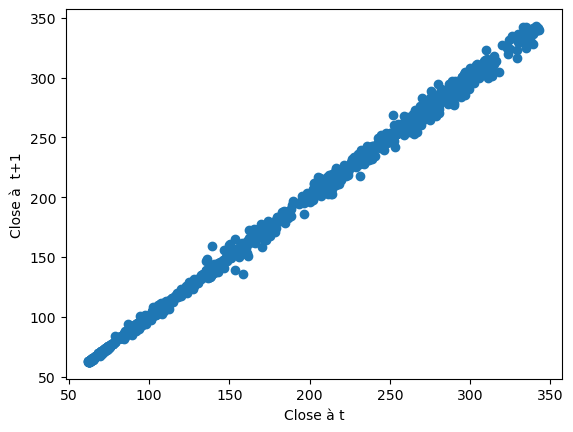

In [7]:
#L'etude d'autocorrélation entre l'observation t et t+1
lag_plot(dataframe)
plt.xlabel('Close à t');
plt.ylabel('Close à  t+1')

Alors,Il existe une forte corrélation entre l'obsérvation close a t et t+1

# 4. Le prétraitement de données

#### <font color=aqua> *4.1 Le remplissage des dates manquantes*</font>
Pour résoudre le problème des jours manquants dans les dates, nous effectuons un rééchantillonnage(Resampling) avec une fréquence quotidienne afin de combler les dates manquantes.

In [8]:
dataframe=dataframe.resample('D').mean()
dataframe=dataframe.interpolate(method='linear')


#### <font color=aqua> *4.3 La Standarisation de  données*</font>

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_sc=scaler.fit_transform(dataframe)
len(df_sc)


2067

## 5. Création de Modèle ANN

#### <font color=aqua> *5.1 La division de dataset*</font>

nous prendrons 80% de données pour l'entrainement,et 20% pour le test de modèle.

In [10]:
#La dévision de dataset en train et test
train,test = train_test_split(df_sc, test_size=0.2, shuffle=False)
#La construction des features et target respectivement X,y
X_train,y_train,X_test,y_test=[],[],[],[]
#La contruction de dataset sous forme de problème de Machine Learnnig avec un window égal 1
for i in range(1,len(train)):
    X_train.append(train[i-1])
    y_train.append(train[i])
for i in range(1,len(test)):
    X_test.append(test[i-1])
    y_test.append(test[i])
X_train,y_train=np.array(X_train),np.array(y_train)
X_test,y_tet=np.array(X_test),np.array(y_test)


#### <font color=aqua> *5.2 La création de Modèle*</font>

In [11]:
ann = Sequential()
ann.add(Dense(3,activation='tanh',input_dim=1))
ann.add(Dense(1))
ann.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = ann.fit(X_train, y_train, batch_size = 32, epochs = 100, callbacks=[early_stop], validation_split=0.2)



Epoch 1/100

42/42 [==============================] - 5s 30ms/step - loss: 1.0944 - val_loss: 0.2964
Epoch 2/100
42/42 [==============================] - 1s 14ms/step - loss: 0.6738 - val_loss: 0.3991
Epoch 3/100
42/42 [==============================] - 1s 14ms/step - loss: 0.4065 - val_loss: 0.4965
Epoch 4/100
42/42 [==============================] - 1s 15ms/step - loss: 0.2510 - val_loss: 0.5779
Epoch 5/100
42/42 [==============================] - 1s 14ms/step - loss: 0.1667 - val_loss: 0.6362
Epoch 6/100
42/42 [==============================] - 1s 14ms/step - loss: 0.1237 - val_loss: 0.6689
Epoch 7/100
42/42 [==============================] - 1s 16ms/step - loss: 0.1023 - val_loss: 0.6802
Epoch 8/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0911 - val_loss: 0.6712
Epoch 9/100
42/42 [==============================] - 1s 16ms/step - loss: 0.0843 - val_loss: 0.6504
Epoch 10/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0790 - val_loss: 0.6

42/42 [==============================] - 1s 20ms/step - loss: 6.5693e-04 - val_loss: 0.0030
Epoch 75/100
42/42 [==============================] - 1s 15ms/step - loss: 6.5333e-04 - val_loss: 0.0030
Epoch 76/100
42/42 [==============================] - 1s 15ms/step - loss: 6.4974e-04 - val_loss: 0.0030
Epoch 77/100
42/42 [==============================] - 1s 16ms/step - loss: 6.4746e-04 - val_loss: 0.0030
Epoch 78/100
42/42 [==============================] - 1s 19ms/step - loss: 6.4300e-04 - val_loss: 0.0030
Epoch 79/100
42/42 [==============================] - 1s 21ms/step - loss: 6.3986e-04 - val_loss: 0.0029
Epoch 80/100
42/42 [==============================] - 1s 20ms/step - loss: 6.3729e-04 - val_loss: 0.0028
Epoch 81/100
42/42 [==============================] - 1s 15ms/step - loss: 6.3366e-04 - val_loss: 0.0029
Epoch 82/100
42/42 [==============================] - 1s 21ms/step - loss: 6.2933e-04 - val_loss: 0.0029
Epoch 83/100
42/42 [==============================] - 1s 15ms/step -

#### <font color=aqua> *5.3 La visualisation des pertes de modèle*</font>

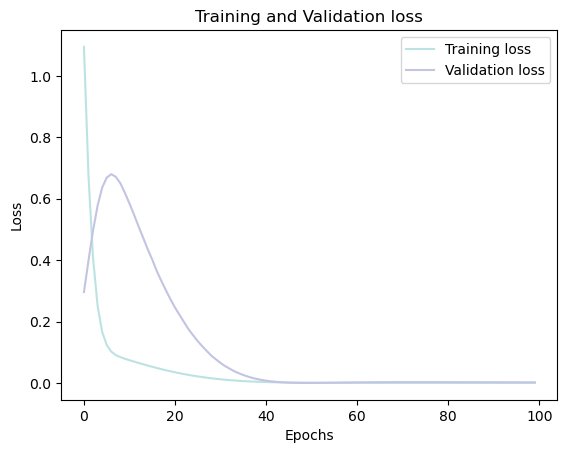

In [12]:
history_df = pd.DataFrame(history.history)
plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

#### <font color=aqua> *5.4 La comparaison graphique de modèle avec les données réels*</font>

52/52 [==============================] - 1s 10ms/step


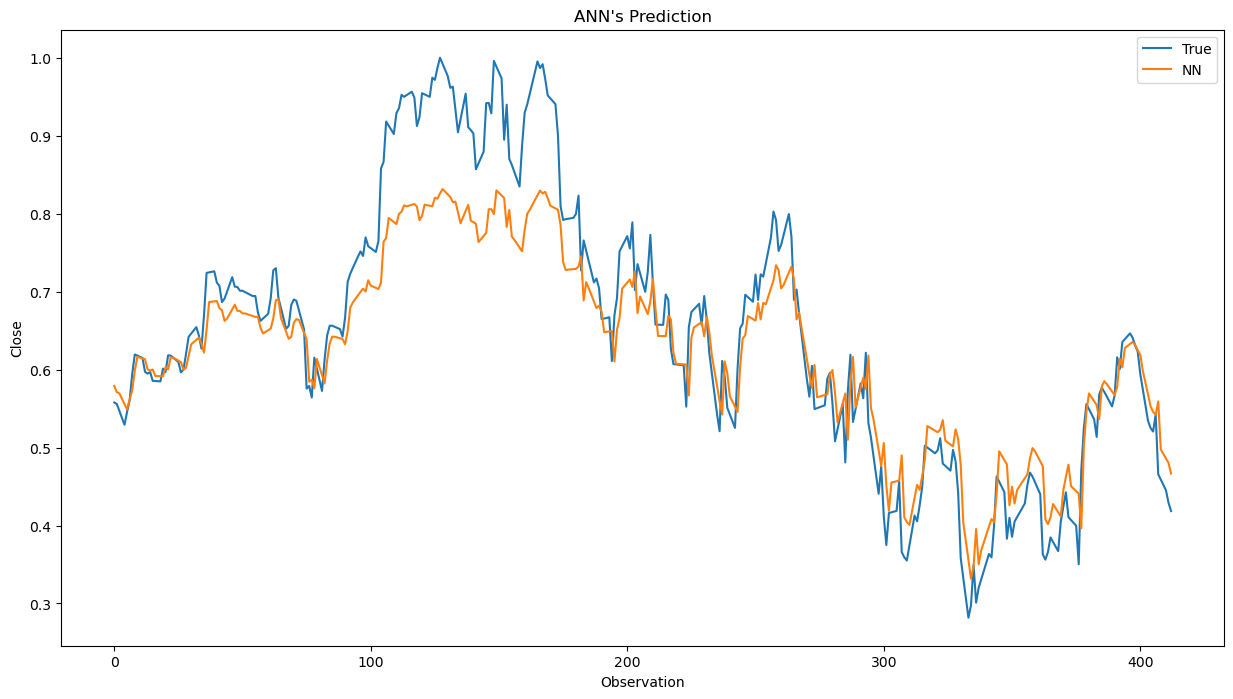

In [13]:
#La prédiction de partie test a travers le modèle
y_pred_test_nn = ann.predict(X_test)
y_train_pred_nn = ann.predict(X_train)
plt.figure(figsize=(15, 8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Close')
plt.legend()
plt.show();

In [16]:

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))


The R2 score on the Train set is:	0.995
The R2 score on the Test set is:	0.849


In [17]:
#Le calcul de la racine des erreurs entre les vraies et prédictives valeurs
RMSE=mean_squared_error(y_test,y_pred_test_nn)
RMSE

0.004506836961734565

En conclusion,Nous pouvons accpter le modèle car la valeur de  RMSE  est faible.